In [9]:
from keras.layers import Input, Dense, Dropout, Activation, LSTM, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Reshape
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.pooling import GlobalAveragePooling1D
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.initializers import RandomUniform
from keras.layers import Dense, Input, Embedding, Dropout, Activation, Reshape
from keras.layers.merge import concatenate, dot
from keras.layers.core import Reshape
from keras import backend as K
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import tensorflow as tf
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
import numpy as np

In [10]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def neg_sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return 1 - true_positives / (possible_positives + K.epsilon())

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [36]:
def get_model():
    kernel_size = 5
    filters = 5
    stride_width = 1
    stirde_height = 3
    pool_size = 4
    
    inp = Input(shape = (2, 64, 120, 3))
    mat1 = Lambda(lambda x: x[:, 0])(inp)
    mat2 = Lambda(lambda x: x[:, 1])(inp)
    mat1 = Convolution2D(filters = 10, kernel_size = 5, 
                                         strides = (2, 5), activation = 'relu')(mat1)
    mat2 = Convolution2D(filters = 10, kernel_size = 5, 
                                         strides = (2, 5), activation = 'relu')(mat2)
    mat1 = MaxPooling2D(pool_size = 2, strides = 2)(mat1)
    mat2 = MaxPooling2D(pool_size = 2, strides = 2)(mat2)
    mat1 = Convolution2D(filters = 5, kernel_size = 2, 
                                         strides = (1, 1), activation = 'relu')(mat1)
    mat2 = Convolution2D(filters = 5, kernel_size = 2, 
                                         strides = (1, 1), activation = 'relu')(mat2)
    
    mat1 = MaxPooling2D(pool_size = 2, strides = 2)(mat1)
    mat2 = MaxPooling2D(pool_size = 2, strides = 2)(mat2)
    #mat1 = TimeDistributed(Dropout(rate = 0.25))(mat1)
    #mat2 = TimeDistributed(Dropout(rate = 0.25))(mat2)
    mat1 = Convolution2D(filters = 3, kernel_size = 2, 
                                         strides = (1, 1), activation = 'relu')(mat1)
    mat2 = Convolution2D(filters = 3, kernel_size = 2, 
                                         strides = (1, 1), activation = 'relu')(mat2)
    mat1 = MaxPooling2D(pool_size = 2, strides = 2)(mat1)
    mat2 = MaxPooling2D(pool_size = 2, strides = 2)(mat2)
    mat1 = Flatten()(mat1)
    mat2 = Flatten()(mat2)
    
    vec3 = dot([mat1, mat2], axes = 1)
    vec4 = concatenate([mat1, mat2, vec3])

    vec4 = Dense(100,  activation='relu')(vec4)
    #vec4 = Dropout(rate=0.25)(vec4)
    preds = Dense(1, activation='sigmoid')(vec4)
    
    model = Model(inputs=inp, outputs=preds)
    
    opt = Adam(lr=0.001, decay=1e-6)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics =[sensitivity, 'acc'])
    
    return model
    
get_model()

In [12]:
train_set = np.load('train_set_score.npy')

val_set = np.load('val_set_score.npy')

In [13]:
val_set_bin = np.vectorize(lambda x: int(x))(val_set[:, 2] > 0.5)
idx_1 = np.where(val_set_bin == 1)
idx_1 = np.array(idx_1).reshape(len(idx_1[0]),)
idx_0 = np.where(val_set_bin == 0)
idx_0 = np.random.choice(np.array(idx_0).reshape(len(idx_0[0]),), np.sum(val_set_bin), replace = False)
val_set = val_set[np.append(idx_1, idx_0), :]
print(val_set.shape)


train_set_bin = np.vectorize(lambda x: int(x))(train_set[6000:7400, 2] > 0.5)
print(np.sum(train_set_bin))
print(len(train_set_bin))

(1630, 3)
118
1400


In [14]:
y = train_set[:6000, 2]
y = y.reshape(-1, 1)
print(y)
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(y)
score = kde.score_samples(y)
weight = 1/np.exp(score).reshape(-1,)
print(weight)

[[0.00537116]
 [0.0159039]
 [0.00853313]
 ...
 [1.0]
 [0.00160056]
 [0.0276892]]
[0.60374116 0.59831096 0.60194721 ... 8.10391276 0.60606684 0.59405223]


In [15]:
print(train_set[0][0].shape)

(64, 120, 3)


In [16]:
n_steps = 20 #10seconds
n_lap = 10 #5seconds

train_x = []
train_y = []

for i in range(6000):
    image1 = train_set[i][0]
    image2 = train_set[i][1]
    y = int(train_set[i][2] > 0.5)
    #y = train_set[i][2]
    train_x.append(np.array([image1, image2]))
    train_y.append(y)
    
train_x = np.array(train_x)
print(train_x.shape)
train_y = np.array(train_y)
print(train_y.shape)

validation_x = []
validation_y = []
for i in range(6000, 7400):
    image1 = train_set[i][0]
    image2 = train_set[i][1]
    y = int(train_set[i][2] > 0.5)
    #y = train_set[i][2]
    validation_x.append(np.array([image1, image2]))
    validation_y.append(y)
    
validation_x = np.array(validation_x)
print(validation_x.shape)
validation_y = np.array(validation_y)
print(validation_y.shape)

test_x = []
test_y = []
for i in range(len(val_set)):
    image1 = val_set[i][0]
    image2 = val_set[i][1]
    y = int(val_set[i][2] > 0.5)
    #y = val_set[i][2]
    test_x.append(np.array([image1, image2]))
    test_y.append(y)
    
test_x = np.array(test_x)
print(test_x.shape)
test_y = np.array(test_y)
print(test_y.shape)



(6000, 2, 64, 120, 3)
(6000,)
(1400, 2, 64, 120, 3)
(1400,)
(1630, 2, 64, 120, 3)
(1630,)


Train on 6000 samples, validate on 1630 samples
Epoch 1/200
6000/6000 [==============================] - 5s 778us/step - loss: 1.9962 - sensitivity: 0.5422 - acc: 0.4937 - val_loss: 0.7102 - val_sensitivity: 0.2526 - val_acc: 0.5184
Epoch 2/200
6000/6000 [==============================] - 3s 490us/step - loss: 1.2673 - sensitivity: 0.4826 - acc: 0.5290 - val_loss: 0.6943 - val_sensitivity: 0.1838 - val_acc: 0.5160
Epoch 3/200
6000/6000 [==============================] - 3s 502us/step - loss: 1.2506 - sensitivity: 0.5506 - acc: 0.5215 - val_loss: 0.7007 - val_sensitivity: 0.3272 - val_acc: 0.5209
Epoch 4/200
6000/6000 [==============================] - 3s 505us/step - loss: 1.2478 - sensitivity: 0.4796 - acc: 0.6008 - val_loss: 0.6925 - val_sensitivity: 0.2196 - val_acc: 0.5294
Epoch 5/200
6000/6000 [==============================] - 3s 496us/step - loss: 1.2419 - sensitivity: 0.5713 - acc: 0.5527 - val_loss: 0.6910 - val_sensitivity: 0.3519 - val_acc: 0.5380
Epoch 6/200
6000/6000 [====

Epoch 45/200
6000/6000 [==============================] - 3s 486us/step - loss: 0.8107 - sensitivity: 0.8601 - acc: 0.7433 - val_loss: 0.6703 - val_sensitivity: 0.3863 - val_acc: 0.7252
Epoch 46/200
6000/6000 [==============================] - 3s 484us/step - loss: 0.8177 - sensitivity: 0.8258 - acc: 0.7463 - val_loss: 0.6239 - val_sensitivity: 0.3906 - val_acc: 0.7374
Epoch 47/200
6000/6000 [==============================] - 3s 486us/step - loss: 0.8275 - sensitivity: 0.8279 - acc: 0.7443 - val_loss: 0.6414 - val_sensitivity: 0.3847 - val_acc: 0.7325
Epoch 48/200
6000/6000 [==============================] - 3s 541us/step - loss: 0.7511 - sensitivity: 0.8561 - acc: 0.7628 - val_loss: 0.6326 - val_sensitivity: 0.4051 - val_acc: 0.7282
Epoch 49/200
6000/6000 [==============================] - 3s 517us/step - loss: 0.7527 - sensitivity: 0.8920 - acc: 0.7600 - val_loss: 0.6586 - val_sensitivity: 0.4020 - val_acc: 0.7380
Epoch 50/200
6000/6000 [==============================] - 3s 506us/ste

6000/6000 [==============================] - 3s 521us/step - loss: 0.5494 - sensitivity: 0.9053 - acc: 0.8425 - val_loss: 0.7209 - val_sensitivity: 0.4356 - val_acc: 0.7883
Epoch 90/200
6000/6000 [==============================] - 3s 511us/step - loss: 0.5043 - sensitivity: 0.9282 - acc: 0.8470 - val_loss: 0.7700 - val_sensitivity: 0.4237 - val_acc: 0.8123
Epoch 91/200
6000/6000 [==============================] - 3s 496us/step - loss: 0.5000 - sensitivity: 0.9501 - acc: 0.8462 - val_loss: 0.8144 - val_sensitivity: 0.3830 - val_acc: 0.8055
Epoch 92/200
6000/6000 [==============================] - 3s 510us/step - loss: 0.5073 - sensitivity: 0.9179 - acc: 0.8490 - val_loss: 0.7679 - val_sensitivity: 0.4178 - val_acc: 0.8074
Epoch 93/200
6000/6000 [==============================] - 3s 501us/step - loss: 0.4868 - sensitivity: 0.9490 - acc: 0.8630 - val_loss: 0.7659 - val_sensitivity: 0.4227 - val_acc: 0.7963
Epoch 94/200
6000/6000 [==============================] - 3s 518us/step - loss: 0.4

Epoch 133/200
6000/6000 [==============================] - 3s 488us/step - loss: 0.3333 - sensitivity: 0.9746 - acc: 0.9057 - val_loss: 0.9458 - val_sensitivity: 0.4112 - val_acc: 0.8417
Epoch 134/200
6000/6000 [==============================] - 3s 493us/step - loss: 0.3240 - sensitivity: 0.9799 - acc: 0.9082 - val_loss: 0.9205 - val_sensitivity: 0.4070 - val_acc: 0.8399
Epoch 135/200
6000/6000 [==============================] - 3s 560us/step - loss: 0.3335 - sensitivity: 0.9763 - acc: 0.9107 - val_loss: 0.9385 - val_sensitivity: 0.4057 - val_acc: 0.8356
Epoch 136/200
6000/6000 [==============================] - 3s 519us/step - loss: 0.3272 - sensitivity: 0.9738 - acc: 0.9050 - val_loss: 0.8995 - val_sensitivity: 0.4239 - val_acc: 0.8258
Epoch 137/200
6000/6000 [==============================] - 3s 499us/step - loss: 0.3647 - sensitivity: 0.9695 - acc: 0.8985 - val_loss: 0.9349 - val_sensitivity: 0.4008 - val_acc: 0.8227
Epoch 138/200
6000/6000 [==============================] - 3s 502

Epoch 177/200
6000/6000 [==============================] - 3s 505us/step - loss: 0.2534 - sensitivity: 0.9672 - acc: 0.9252 - val_loss: 1.0373 - val_sensitivity: 0.4082 - val_acc: 0.8399
Epoch 178/200
6000/6000 [==============================] - 3s 496us/step - loss: 0.2249 - sensitivity: 0.9887 - acc: 0.9413 - val_loss: 1.0609 - val_sensitivity: 0.4106 - val_acc: 0.8405
Epoch 179/200
6000/6000 [==============================] - 3s 492us/step - loss: 0.2428 - sensitivity: 0.9854 - acc: 0.9335 - val_loss: 1.0533 - val_sensitivity: 0.4063 - val_acc: 0.8399
Epoch 180/200
6000/6000 [==============================] - 3s 500us/step - loss: 0.2554 - sensitivity: 0.9788 - acc: 0.9307 - val_loss: 1.0164 - val_sensitivity: 0.4168 - val_acc: 0.8337
Epoch 181/200
6000/6000 [==============================] - 3s 499us/step - loss: 0.2679 - sensitivity: 0.9526 - acc: 0.9265 - val_loss: 1.0283 - val_sensitivity: 0.4070 - val_acc: 0.8325
Epoch 182/200
6000/6000 [==============================] - 3s 512

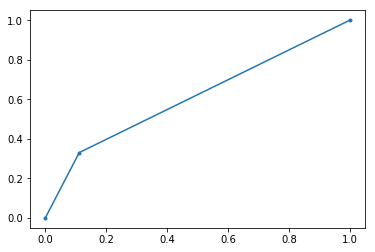

0.8515337423312883
[[750  65]
 [177 638]]


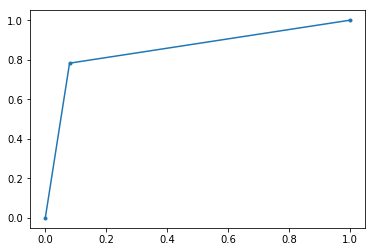

In [37]:
model = get_model()
early_stopping = EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience = 90)

model.fit(train_x, train_y, validation_data=(validation_x, validation_y), 
    epochs=200, class_weight = {0:1, 1:10}, batch_size=100,shuffle=True)

preds_val = model.predict(validation_x, batch_size = 100)
val_acc = accuracy_score(preds_val > 0.5, validation_y > 0.5)
fpr, tpr, thresholds = roc_curve(validation_y > 0.5, preds_val > 0.5)
conf_mat = confusion_matrix(validation_y > 0.5, preds_val > 0.5)
print(val_acc)
print(conf_mat)
plt.plot(fpr, tpr, marker = '.')
plt.show()

preds_test = model.predict(test_x, batch_size = 100)
test_acc = accuracy_score(preds_test > 0.5, test_y > 0.5)
fpr, tpr, thresholds = roc_curve(test_y > 0.5, preds_test > 0.5)
conf_mat = confusion_matrix(test_y > 0.5, preds_test > 0.5)
print(test_acc)
print(conf_mat)
plt.plot(fpr, tpr, marker = '.')
plt.show()